In [1]:
import os
import xarray as xr
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import boto3
from io import BytesIO, StringIO
import gzip
import requests
from bs4 import BeautifulSoup
import zipfile

import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

In [2]:
# from maritime_clean.py
def get_elevs(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('pre')

    # Table 1 is smaller than table 2 and 3 by one column
    # Start with table 1
    tabletext = tables[0]
    columns = ["Station_ID", "Site_Elevation", "Air_Temp_Elevation", "Anemometer_Elevation", "Barometer_Elevation"]
    table = tabletext.get_text().rsplit('ELEVATION',1)[1] # Remove headers
    table = table.split() # Remove whitespace
    # Should be 5 for table 0 and 6 for table 1+2
    composite_list = [table[x:x+5] for x in range(0, len(table),5)] # Split into rows
    df = pd.DataFrame(composite_list)
    df.columns = columns
    df['Tide_Reference'] = np.NAN # Add 6th column -- don't really  need this column, drop in update
#     df = df.reindex(columns = ["Station_ID", "Site_Elevation", "Air_Temp_Elevation", "Anemometer_Elevation", "Tide_Reference", "Barometer_Elevation"])

    # Table 2 has 6 columns
    tabletext = tables[1]
    columns = ["Station_ID", "Site_Elevation", "Air_Temp_Elevation", "Anemometer_Elevation", "Tide_Reference", "Barometer_Elevation"]
    table = tabletext.get_text().rsplit('ELEVATION',1)[1] # Remove headers
    table = table.split() # Remove whitespace
    # Should be 5 for table 0 and 6 for table 1+2
    composite_list = [table[x:x+6] for x in range(0, len(table),6)] # Split into rows
    dftemp = pd.DataFrame(composite_list)
    dftemp.columns = columns
    df = pd.concat([df, dftemp])
    df=df.reset_index(drop=True)

#   Table 3 has 9 columns, but we only want the first 6
    tabletext = tables[2]
    columns = ["Station_ID", "Site_Elevation", "Air_Temp_Elevation", "Anemometer_Elevation", "Tide_Reference", "Barometer_Elevation"]
    table = tabletext.get_text().rsplit('CIRCLE',1)[1] # Remove headers
    table = table.split() # Remove whitespace
    # Should be 5 for table 0 and 6 for table 1+2
    composite_list = [table[x:x+9] for x in range(0, len(table),9)] # Split into rows
    dftemp = pd.DataFrame(composite_list)
    dftemp = dftemp.iloc[:,0:6] # Drop last three columns
    dftemp.columns = columns
    df = pd.concat([df, dftemp])
    df=df.reset_index(drop=True)
    # print(df) # testing
    return df

In [3]:
url = 'https://www.ndbc.noaa.gov/bmanht.shtml'
elevs_df = get_elevs(url)
elevs_df

,Station_ID,Site_Elevation,Air_Temp_Elevation,Anemometer_Elevation,Barometer_Elevation,Tide_Reference
0,41001,0,3.4,3.8,2.4,NaN
1,41002,0,3.7,4.1,2.7,NaN
2,41004,0,3.7,4.1,2.7,NaN
3,41008,0,4.4,4.9,0.3,NaN
4,41009,0,3.7,4.1,2.7,NaN
...,...,...,...,...,...,...
1610,ygnn6,73,6,10,75.3,NA
1611,ykrv2,NA,NA,NA,NA,NA
1612,yktv2,3.7,3.9,9.6,5.6,NA
1613,yrsv2,11,3.5,3.5,14.5,NA


In [4]:
mar_stns = pd.read_csv('stationlist_MARITIME.csv')
mar_stns = mar_stns.iloc[: , 3:] # cleaning up empty cols
ndbc_stns = pd.read_csv('stationlist_NDBC.csv')
ndbc_stns = ndbc_stns.iloc[:, 3:] # cleaning up empty cols

In [5]:
# returns dataframe of stations that have DO NOT have a valid elevation and are in the network stationlist
na_elevs = elevs_df[elevs_df.Site_Elevation.str.contains("NA")]
ndbc_elevs = na_elevs[(na_elevs['Station_ID'].isin(ndbc_stns['STATION_ID']))]
mar_elevs = na_elevs[(na_elevs['Station_ID'].isin(mar_stns['STATION_ID']))]

In [6]:
# subset from each network's station list those buoys from elevs_df that have nan elevation value
empty_ndbc = ndbc_stns[(ndbc_stns['STATION_ID'].isin(ndbc_elevs['Station_ID']))]
empty_mar = mar_stns[(mar_stns['STATION_ID'].isin(mar_elevs['Station_ID']))]

# these were identified by running maritime_clean script and which buoys outputted valid data
mar_valid_wx_buoys = ['chao3','pxac1','smoc1','agxc1','baxc1','mlto3','ohbc1','okxc1','omhc1',
'pfdc1','pfxc1','ppxc1','prjc1','psxc1']
ndbc_valid_wx_buoys = ['46089', '46109', '46110', '46111', '46112', '46113', '46274', '46235']

# grab the buoys out of the empty_buoy dfs that have valid wx data
mar_wx_buoys = empty_mar[(empty_mar['STATION_ID'].isin(mar_valid_wx_buoys))]
ndbc_wx_buoys = empty_ndbc[(empty_ndbc['STATION_ID'].isin(ndbc_valid_wx_buoys))]

# merge these two together
nan_elev_buoys = pd.concat([mar_wx_buoys, ndbc_wx_buoys], axis=0)
nan_elev_buoys

,STATION_ID,OWNER,NAME,LOCATION,LATITUDE,LONGITUDE,in_terr_wecc,in_mar_wecc,NETWORK,Pulled,Time_Checked,NOTE
2,chao3,O,"9432780 - Charleston, OR","43.351 N 124.337 W (43&#176;21'3"" N 124&#176;2...",43.351,-124.337,Y,NaN,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
33,pxac1,PT,"9410690 - Los Angeles Berth 161, CA","33.764 N 118.265 W (33&#176;45'49"" N 118&#176;...",33.764,-118.265,Y,NaN,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
42,smoc1,O,"9410840 - Santa Monica, CA","34.008 N 118.500 W (34&#176;0'30"" N 118&#176;3...",34.008,-118.500,Y,NaN,MARITIME,Y,2022-11-15 15:51:49+00:00,"As of 1800 UTC, January 22, 2010; observations..."
53,agxc1,PT,"9410647 - Angels Gate, CA","33.716 N 118.246 W (33&#176;42'57"" N 118&#176;...",33.716,-118.246,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
55,baxc1,PT,9410691 - Los Angeles Badger Avenue Bridge,"33.766 N 118.240 W (33&#176;45'59"" N 118&#176;...",33.766,-118.240,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
82,mlto3,D,"Marsh Island, OR","46.214 N 123.620 W (46&#176;12'51"" N 123&#176;...",46.214,-123.620,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
89,ohbc1,O,"9410660 - Los Angeles, CA","33.720 N 118.273 W (33&#176;43'12"" N 118&#176;...",33.720,-118.273,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
90,okxc1,PT,"9414776 - Oakland Berth 34, CA","37.811 N 122.333 W (37&#176;48'38"" N 122&#176;...",37.811,-122.333,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
91,omhc1,PT,"9414769 - Oakland Middle Harbor Met, CA","37.801 N 122.330 W (37&#176;48'2"" N 122&#176;1...",37.801,-122.330,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN
94,pfdc1,PT,"9410666 - Los Angeles Pier 400, CA","33.735 N 118.241 W (33&#176;44'7"" N 118&#176;1...",33.735,-118.241,Y,Y,MARITIME,Y,2022-11-15 15:51:49+00:00,NaN


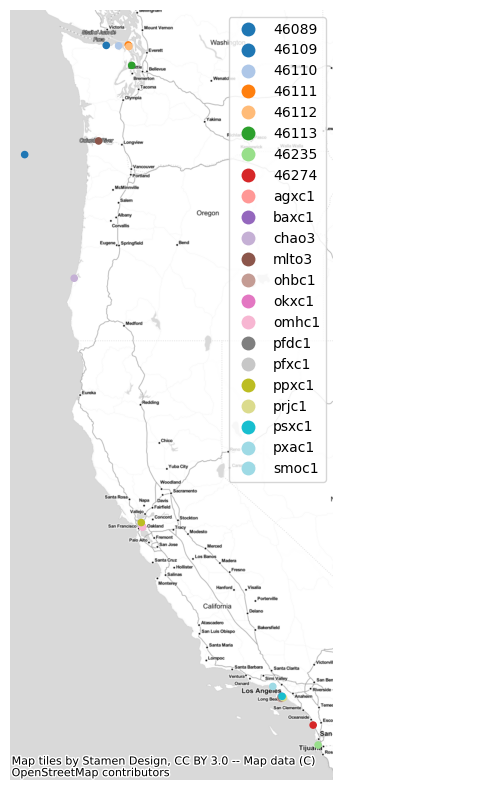

In [45]:
# set up figure
gdf = gpd.GeoDataFrame(nan_elev_buoys, geometry=gpd.points_from_xy(nan_elev_buoys.LONGITUDE, nan_elev_buoys.LATITUDE))
# gdf = gdf.query('45 < LATITUDE < 52')
# gdf = gdf.query('-117.5 < LONGITUDE < -117')
gdf.set_crs(epsg=4326, inplace=True) # Set CRS
gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

# clip basemap to buoys
shapepath = "tl_2021_us_state.shp"
us = gpd.read_file(shapepath)
us = us.to_crs(epsg = 3857)
gdf_us = gdf_wm.clip(us)

# plot figure
ax = gdf_wm.plot("STATION_ID", figsize=(10,10), markersize=20, legend=True, cmap='tab20')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# ax.figure.savefig("empty_buoys_all_fnl.pdf", format='pdf', bbox_inches='tight')